In [ ]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================
# Standard libraries
import os
import random
import numpy as np
import zipfile
from pathlib import Path
import time
import gc

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

# Progress bar
from tqdm import tqdm

# OpenCV for quality metrics
import cv2

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!ls /content/drive/MyDrive/'NEU - MS CS'/3_SEM/'CS - 7150 (DeepLearning)'/midterm-proj-1/data

faceforensics_dataset.zip


In [ ]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

CONFIG = {
    # Data paths
    'zip_path': '/content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1/data/faceforensics_dataset.zip',
    'extract_dir': '/content/extracted_data',
    # 'save_dir': '/content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1/models/cnn_vae_combined',
    'save_dir': '/content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1/models/cnn_vae_combined_weighted_bce',

    # Training
    'batch_size': 64,
    'num_workers': 2,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'checkpoint_interval': 10000,

    # Data split
    'train_ratio': 0.9,
    'test_ratio': 0.1,

    # Model architecture
    'input_channels': 3,
    'image_size': 64,
    'num_classes': 2,

    # VAE architecture
    'vae_hidden_channels': [32, 64, 128],
    'vae_out_channels': 256,
    'latent_dim': 128,

    # Loss function
    'loss_type': 'weighted_bce',

    # VAE pretraining
    'vae_pretrain_epochs': 5,
    'vae_pretrain': True,  # Set to False to skip VAE pretraining
}

os.makedirs(CONFIG['save_dir'], exist_ok=True)
os.makedirs(CONFIG['extract_dir'], exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla T4


In [ ]:
# ============================================================================
# SECTION 3: MOUNT DRIVE AND LOAD DATA
# ============================================================================
# from google.colab import drive

# Mount drive only if not already mounted
# if not os.path.exists('/content/drive/MyDrive'):
#     drive.mount('/content/drive')
# else:
#     print("Google Drive already mounted")

from google.colab import drive
drive.mount('/content/drive')

# Define tensor paths
X_path = os.path.join(CONFIG['extract_dir'], 'FaceForensics_X.pt')
y_path = os.path.join(CONFIG['extract_dir'], 'FaceForensics_y.pt')

# Extract only if tensor files don't exist
if not os.path.exists(X_path) or not os.path.exists(y_path):
    print(f"Extracting dataset from zip file...")

    # Use pathlib to handle spaces properly
    from pathlib import Path
    zip_path = Path(CONFIG['zip_path'])

    if not zip_path.exists():
        raise FileNotFoundError(f"Zip file not found at: {CONFIG['zip_path']}")

    with zipfile.ZipFile(str(zip_path), 'r') as zip_ref:
        zip_ref.extractall(CONFIG['extract_dir'])
    print("Extraction complete")
else:
    print("Dataset already extracted")

# Load tensors
print(f"Loading tensors...")
X = torch.load(X_path)
y = torch.load(y_path)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Label distribution: Real (0): {(y==0).sum()}, Fake (1): {(y==1).sum()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting dataset from zip file...
Extraction complete
Loading tensors...
X shape: torch.Size([99600, 3, 64, 64]), y shape: torch.Size([99600])
Label distribution: Real (0): 49800, Fake (1): 49800


In [ ]:
# ============================================================================
# SECTION 6: VAE ARCHITECTURE
# ============================================================================
class ConvEncoder(nn.Module):
    """VAE Encoder: Image → Latent Space (mu, logvar)"""
    def __init__(self, in_channels=3, hidden_channels=[32, 64, 128],
                 out_channels=256, input_height=64, input_width=64, latent_dim=128):
        super().__init__()

        output_height = input_height // 2 ** (len(hidden_channels) + 1)
        output_width = input_width // 2 ** (len(hidden_channels) + 1)

        layers = []
        layers.append(nn.Conv2d(in_channels, hidden_channels[0], kernel_size=4, stride=2, padding=1))
        layers.append(nn.ReLU(True))

        for k in range(len(hidden_channels)-1):
            layers.append(nn.Conv2d(hidden_channels[k], hidden_channels[k+1], kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(hidden_channels[k+1]))
            layers.append(nn.ReLU(True))

        layers.append(nn.Conv2d(hidden_channels[-1], out_channels, kernel_size=4, stride=2, padding=1))
        self.net = nn.Sequential(*layers)

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(out_channels * output_height * output_width, latent_dim)
        self.fc_logvar = nn.Linear(out_channels * output_height * output_width, latent_dim)

    def forward(self, x):
        x = self.net(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class ConvDecoder(nn.Module):
    """VAE Decoder: Latent Space → Reconstructed Image"""
    def __init__(self, in_channels=256, hidden_channels=[128, 64, 32],
                 out_channels=3, output_height=64, output_width=64, latent_dim=128):
        super().__init__()

        self.in_channels = in_channels
        self.input_height = output_height // 2 ** (len(hidden_channels) + 1)
        self.input_width = output_width // 2 ** (len(hidden_channels) + 1)

        self.fc = nn.Linear(latent_dim, self.in_channels * self.input_height * self.input_width)

        layers = []
        layers.append(nn.ConvTranspose2d(in_channels, hidden_channels[0], kernel_size=4, stride=2, padding=1))
        layers.append(nn.ReLU(True))

        for k in range(len(hidden_channels)-1):
            layers.append(nn.ConvTranspose2d(hidden_channels[k], hidden_channels[k+1], kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(hidden_channels[k+1]))
            layers.append(nn.ReLU(True))

        layers.append(nn.ConvTranspose2d(hidden_channels[-1], out_channels, kernel_size=4, stride=2, padding=1))
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.in_channels, self.input_height, self.input_width)
        x = self.net(x)
        return x

class VAE(nn.Module):
    """Complete VAE: Encoder + Decoder with reparameterization"""
    def __init__(self, in_channels=3, hidden_channels=[32, 64, 128],
                 out_channels=256, height=64, width=64, latent_dim=128):
        super().__init__()
        self.encoder = ConvEncoder(in_channels, hidden_channels, out_channels, height, width, latent_dim)
        self.decoder = ConvDecoder(out_channels, hidden_channels[::-1], in_channels, height, width, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [ ]:
# ============================================================================
# SECTION 7: CNN ARCHITECTURE
# ============================================================================
class SimpleCNN(nn.Module):
    """CNN Classifier: Image → Class Logits (Real/Fake)"""
    def __init__(self, input_channels=3, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

----

## Load model

In [ ]:
# Load saved model
checkpoint = torch.load(os.path.join(CONFIG['save_dir'], 'final_combined_model_weighted_bce.pt'))

# Recreate models
cnn = SimpleCNN(input_channels=3, num_classes=2).to(device)
vae = VAE(in_channels=3, hidden_channels=[32,64,128], out_channels=256, height=64, width=64, latent_dim=128).to(device)

# Load weights
cnn.load_state_dict(checkpoint['cnn_state_dict'])
vae.load_state_dict(checkpoint['vae_state_dict'])
cnn.eval()
vae.eval()

print("✅ Models loaded")

✅ Models loaded


In [ ]:
# ============================================================================
# SECTION 4: SHUFFLE AND SPLIT DATA
# ============================================================================
num_samples = X.shape[0]
indices = torch.randperm(num_samples)
X = X[indices]
y = y[indices]

train_size = int(num_samples * CONFIG['train_ratio'])
test_size = num_samples - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Extract real images for VAE training
real_mask = y_train == 0
X_train_real = X_train[real_mask]
print(f"Real images for VAE training: {len(X_train_real)}")

# Clean up
del X, y, indices
gc.collect()

Train: 89640, Test: 9960
Real images for VAE training: 44839


25

---

In [ ]:
# Recreate test_loader from checkpoint data
# Note: You need to have test data available

# Option 1: If you still have X_test and y_test in memory
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'],
                         shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)

print(f"✅ Test loader recreated: {len(test_loader)} batches")

✅ Test loader recreated: 156 batches


In [ ]:
# Run evaluation to get predictions
print("Running evaluation to generate predictions...")

cnn.eval()
all_predictions = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn(images)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"✅ Evaluation complete")
print(f"   Predictions: {len(all_predictions)}")
print(f"   Accuracy: {accuracy_score(all_labels, all_predictions)*100:.2f}%")

Running evaluation to generate predictions...


Evaluating: 100%|██████████| 156/156 [00:01<00:00, 110.42it/s]

✅ Evaluation complete
   Predictions: 9960
   Accuracy: 99.00%


In [ ]:
# ============================================================================
# SECTION 14: FEATURE EXTRACTION FOR VISUALIZATION
# ============================================================================
print(f"\n{'='*60}")
print("🧠 EXTRACTING fc1 FEATURES (128-D)")
print(f"{'='*60}")

class FeatureExtractor(nn.Module):
    """
    Wrapper around SimpleCNN to extract fc1 features
    instead of final predictions
    """
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.conv1 = original_model.conv1
        self.relu1 = original_model.relu1
        self.pool1 = original_model.pool1
        self.conv2 = original_model.conv2
        self.relu2 = original_model.relu2
        self.pool2 = original_model.pool2
        self.flatten = original_model.flatten
        self.fc1 = original_model.fc1
        self.relu3 = original_model.relu3

    def forward(self, x):
        """Forward pass that stops at fc1 - Returns 128-dimensional features"""
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)

        return x

# Create feature extractor from trained CNN
feature_extractor = FeatureExtractor(cnn)
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

print("✅ Feature extractor created")
print(f"   Extracts features from: fc1 layer (128-D)")

# Extract features from test set
all_fc1_features = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Extracting fc1 features"):
        images = images.to(device)
        fc1_features = feature_extractor(images)
        all_fc1_features.append(fc1_features.cpu().numpy())

all_fc1_features = np.concatenate(all_fc1_features, axis=0)

print(f"\n✅ Feature extraction complete!")
print(f"   Shape: {all_fc1_features.shape}")
print(f"   Memory: {all_fc1_features.nbytes / (1024**2):.2f} MB")


🧠 EXTRACTING fc1 FEATURES (128-D)
✅ Feature extractor created
   Extracts features from: fc1 layer (128-D)


Extracting fc1 features: 100%|██████████| 156/156 [00:00<00:00, 258.00it/s]


✅ Feature extraction complete!
   Shape: (9960, 128)
   Memory: 4.86 MB



🔄 APPLYING 2D t-SNE

⏳ Running t-SNE dimensionality reduction to 2D...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9960 samples in 0.001s...
[t-SNE] Computed neighbors for 9960 samples in 0.489s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9960
[t-SNE] Computed conditional probabilities for sample 2000 / 9960
[t-SNE] Computed conditional probabilities for sample 3000 / 9960
[t-SNE] Computed conditional probabilities for sample 4000 / 9960
[t-SNE] Computed conditional probabilities for sample 5000 / 9960
[t-SNE] Computed conditional probabilities for sample 6000 / 9960
[t-SNE] Computed conditional probabilities for sample 7000 / 9960
[t-SNE] Computed conditional probabilities for sample 8000 / 9960
[t-SNE] Computed conditional probabilities for sample 9000 / 9960
[t-SNE] Computed conditional probabilities for sample 9960 / 9960
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.937027
[t-SNE] KL divergenc

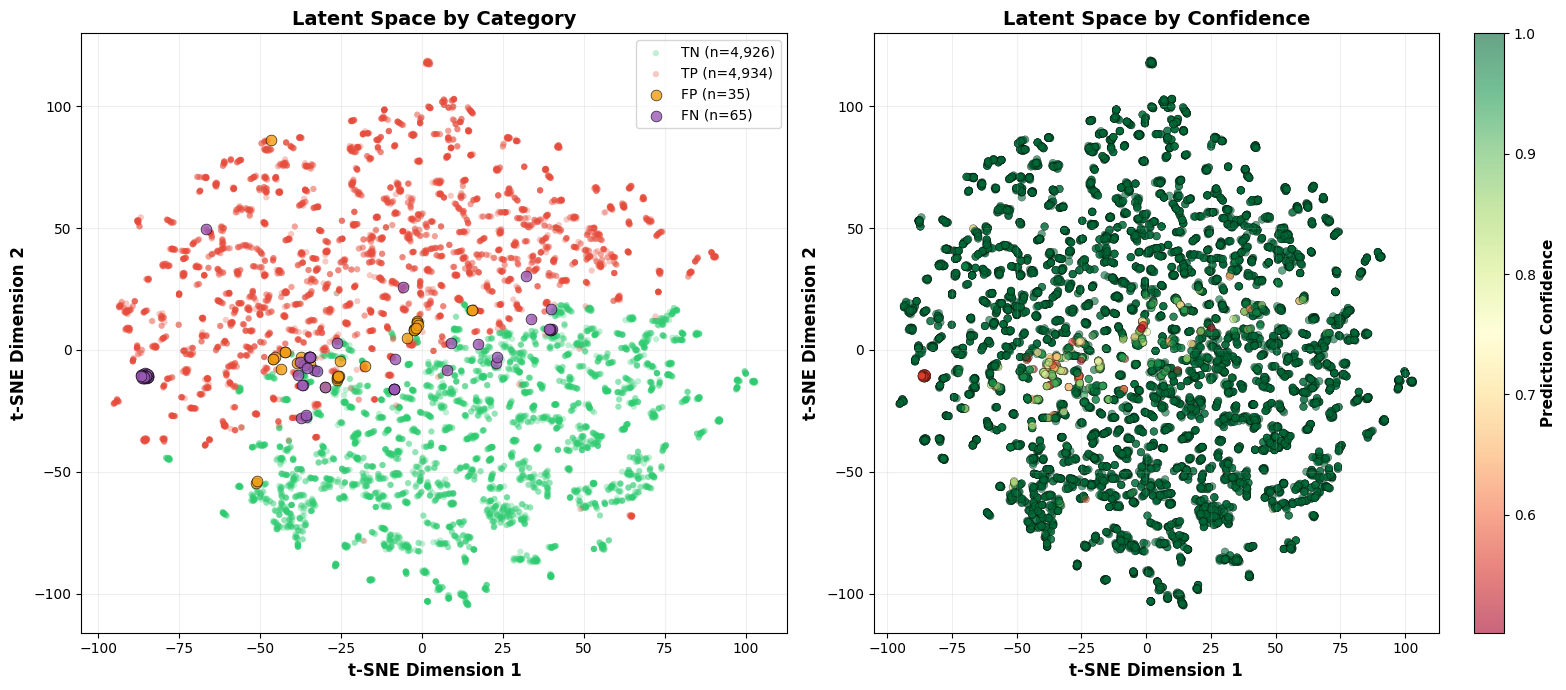

✅ 2D visualizations saved


In [ ]:
# ============================================================================
# SECTION 15: 2D VISUALIZATION WITH t-SNE
# ============================================================================
print(f"\n{'='*60}")
print("🔄 APPLYING 2D t-SNE")
print(f"{'='*60}")

from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

print("\n⏳ Running t-SNE dimensionality reduction to 2D...")

tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    random_state=RANDOM_SEED,
    verbose=1
)

start_time = time.time()
fc1_2d = tsne.fit_transform(all_fc1_features)
elapsed = time.time() - start_time

print(f"\n✅ t-SNE complete in {elapsed:.2f} seconds!")
print(f"   Original: {all_fc1_features.shape[1]}-D → Reduced: {fc1_2d.shape[1]}-D")

# Create category labels
categories = np.empty(len(all_labels), dtype=object)

for i in range(len(all_labels)):
    true_label = all_labels[i]
    pred_label = all_predictions[i]

    if true_label == 0 and pred_label == 0:
        categories[i] = 'TN'
    elif true_label == 1 and pred_label == 1:
        categories[i] = 'TP'
    elif true_label == 0 and pred_label == 1:
        categories[i] = 'FP'
    elif true_label == 1 and pred_label == 0:
        categories[i] = 'FN'

# Category distribution
unique_categories, counts = np.unique(categories, return_counts=True)

print("\n📊 Category Distribution:")
category_names = {
    'TN': 'True Negatives  (Real → Real) ✅',
    'TP': 'True Positives  (Fake → Fake) ✅',
    'FP': 'False Positives (Real → Fake) ❌',
    'FN': 'False Negatives (Fake → Real) ❌'
}

for cat, count in zip(unique_categories, counts):
    percentage = (count / len(categories)) * 100
    print(f"   {cat}: {count:5,} ({percentage:5.2f}%) - {category_names[cat]}")

# ============================================================================
# SECTION 16: 2D PLOTS
# ============================================================================
print(f"\n{'='*60}")
print("📊 CREATING 2D VISUALIZATIONS")
print(f"{'='*60}")

# Color scheme
color_map = {
    'TN': '#2ecc71',  # Green
    'TP': '#e74c3c',  # Red
    'FP': '#f39c12',  # Orange
    'FN': '#9b59b6'   # Purple
}

# Plot 1: Category-based
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left plot: Categories
for category in ['TN', 'TP', 'FP', 'FN']:
    mask = categories == category
    x_coords = fc1_2d[mask, 0]
    y_coords = fc1_2d[mask, 1]

    if category in ['TN', 'TP']:
        alpha = 0.3
        size = 20
        zorder = 1
    else:
        alpha = 0.8
        size = 60
        zorder = 2

    axes[0].scatter(
        x_coords, y_coords,
        c=color_map[category],
        label=f'{category} (n={mask.sum():,})',
        alpha=alpha,
        s=size,
        edgecolors='black' if category in ['FP', 'FN'] else 'none',
        linewidths=0.5,
        zorder=zorder
    )

axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
axes[0].set_title('Latent Space by Category', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.2)

# Right plot: Confidence
confidences = np.zeros(len(all_predictions))
for i in range(len(all_predictions)):
    pred_class = all_predictions[i]
    confidences[i] = all_probs[i, pred_class]

scatter = axes[1].scatter(
    fc1_2d[:, 0], fc1_2d[:, 1],
    c=confidences,
    cmap='RdYlGn',
    s=30,
    alpha=0.6,
    edgecolors='black',
    linewidths=0.3
)

cbar = plt.colorbar(scatter, ax=axes[1], label='Prediction Confidence')
cbar.set_label('Prediction Confidence', fontsize=11, fontweight='bold')

axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
axes[1].set_title('Latent Space by Confidence', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'latent_space_2d.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✅ 2D visualizations saved")

In [ ]:
# ============================================================================
# SECTION 17: LATENT SPACE ANALYSIS
# ============================================================================
print(f"\n{'='*60}")
print("🔍 LATENT SPACE ANALYSIS")
print(f"{'='*60}")

# Error distribution analysis
fp_coords = fc1_2d[categories == 'FP']
fn_coords = fc1_2d[categories == 'FN']

print("\n📍 Error Distribution:")

if len(fp_coords) > 0:
    fp_std = np.std(fp_coords, axis=0)
    print(f"\n   False Positives (Real→Fake):")
    print(f"   • Count: {len(fp_coords):,}")
    print(f"   • Spread (std): X={fp_std[0]:.2f}, Y={fp_std[1]:.2f}")
    print(f"   • {'Clustered together' if fp_std.mean() < 5 else 'Scattered widely'}")

if len(fn_coords) > 0:
    fn_std = np.std(fn_coords, axis=0)
    print(f"\n   False Negatives (Fake→Real):")
    print(f"   • Count: {len(fn_coords):,}")
    print(f"   • Spread (std): X={fn_std[0]:.2f}, Y={fn_std[1]:.2f}")
    print(f"   • {'Clustered together' if fn_std.mean() < 5 else 'Scattered widely'}")

# Confidence analysis per category
print("\n🎯 Confidence Analysis:")

for category in ['TN', 'TP', 'FP', 'FN']:
    mask = categories == category
    avg_conf = confidences[mask].mean()

    print(f"\n   {category}:")
    print(f"   • Average confidence: {avg_conf:.3f} ({avg_conf*100:.1f}%)")

    if category in ['FP', 'FN']:
        if avg_conf < 0.6:
            print(f"   • ✅ Low confidence errors (model is uncertain)")
        elif avg_conf < 0.8:
            print(f"   • ⚠️ Medium confidence errors (some uncertainty)")
        else:
            print(f"   • 🚨 High confidence errors (model is confidently wrong!)")


🔍 LATENT SPACE ANALYSIS

📍 Error Distribution:

   False Positives (Real→Fake):
   • Count: 35
   • Spread (std): X=19.78, Y=21.47
   • Scattered widely

   False Negatives (Fake→Real):
   • Count: 65
   • Spread (std): X=44.04, Y=12.57
   • Scattered widely

🎯 Confidence Analysis:

   TN:
   • Average confidence: 0.989 (98.9%)

   TP:
   • Average confidence: 0.992 (99.2%)

   FP:
   • Average confidence: 0.662 (66.2%)
   • ⚠️ Medium confidence errors (some uncertainty)

   FN:
   • Average confidence: 0.640 (64.0%)
   • ⚠️ Medium confidence errors (some uncertainty)


In [ ]:
# ============================================================================
# SECTION 18: 3D VISUALIZATION WITH t-SNE
# ============================================================================
print(f"\n{'='*60}")
print("🔄 APPLYING 3D t-SNE")
print(f"{'='*60}")

# Install plotly
import subprocess
subprocess.run(['pip', 'install', '-q', 'plotly'], check=True)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("⏳ Running t-SNE dimensionality reduction to 3D...")

tsne_3d = TSNE(
    n_components=3,
    perplexity=30,
    n_iter=1000,
    random_state=RANDOM_SEED,
    verbose=1
)

start_time = time.time()
fc1_3d = tsne_3d.fit_transform(all_fc1_features)
elapsed = time.time() - start_time

print(f"\n✅ 3D t-SNE complete in {elapsed:.2f} seconds!")
print(f"   Output shape: {fc1_3d.shape}")

x_coords = fc1_3d[:, 0]
y_coords = fc1_3d[:, 1]
z_coords = fc1_3d[:, 2]

# ============================================================================
# SECTION 19: INTERACTIVE 3D PLOTS
# ============================================================================
print(f"\n{'='*60}")
print("📊 CREATING INTERACTIVE 3D VISUALIZATIONS")
print(f"{'='*60}")

# Prepare data for plotly
plot_data = []

category_info = {
    'TN': {'name': 'True Negatives (Real→Real)', 'color': 'rgb(46, 204, 113)', 'symbol': 'circle', 'size': 3},
    'TP': {'name': 'True Positives (Fake→Fake)', 'color': 'rgb(231, 76, 60)', 'symbol': 'circle', 'size': 3},
    'FP': {'name': 'False Positives (Real→Fake)', 'color': 'rgb(243, 156, 18)', 'symbol': 'diamond', 'size': 6},
    'FN': {'name': 'False Negatives (Fake→Real)', 'color': 'rgb(155, 89, 182)', 'symbol': 'diamond', 'size': 6}
}

for category in ['TN', 'TP', 'FP', 'FN']:
    mask = categories == category
    cat_x = x_coords[mask]
    cat_y = y_coords[mask]
    cat_z = z_coords[mask]
    cat_confidences = confidences[mask]
    cat_indices = np.where(mask)[0]

    hover_texts = []
    for i, idx in enumerate(cat_indices):
        hover_text = (
            f"<b>Category:</b> {category}<br>"
            f"<b>Index:</b> {idx}<br>"
            f"<b>True Label:</b> {'Real' if all_labels[idx] == 0 else 'Fake'}<br>"
            f"<b>Predicted:</b> {'Real' if all_predictions[idx] == 0 else 'Fake'}<br>"
            f"<b>Confidence:</b> {cat_confidences[i]:.3f} ({cat_confidences[i]*100:.1f}%)"
        )
        hover_texts.append(hover_text)

    trace = go.Scatter3d(
        x=cat_x, y=cat_y, z=cat_z,
        mode='markers',
        name=f"{category} (n={mask.sum():,})",
        marker=dict(
            size=category_info[category]['size'],
            color=category_info[category]['color'],
            symbol=category_info[category]['symbol'],
            opacity=0.8 if category in ['FP', 'FN'] else 0.4,
            line=dict(
                color='black' if category in ['FP', 'FN'] else 'rgba(0,0,0,0)',
                width=0.5
            )
        ),
        text=hover_texts,
        hovertemplate='%{text}<extra></extra>'
    )
    plot_data.append(trace)

# Create category-based 3D plot
fig_category = go.Figure(data=plot_data)

fig_category.update_layout(
    title={
        'text': '<b>Interactive 3D Latent Space - Category View</b><br>'
                '<sub>fc1 features (128-D) → t-SNE (3-D)</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    scene=dict(
        xaxis=dict(title='<b>t-SNE Dimension 1</b>', backgroundcolor="rgb(230, 230, 230)", gridcolor="white", showbackground=True),
        yaxis=dict(title='<b>t-SNE Dimension 2</b>', backgroundcolor="rgb(230, 230, 230)", gridcolor="white", showbackground=True),
        zaxis=dict(title='<b>t-SNE Dimension 3</b>', backgroundcolor="rgb(230, 230, 230)", gridcolor="white", showbackground=True),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    legend=dict(
        title="<b>Categories</b>",
        font=dict(size=11),
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1
    ),
    width=1000,
    height=800,
    hovermode='closest'
)

fig_category.show()
print("✅ Category-based 3D plot created")

# Create confidence-based 3D plot
fig_confidence = go.Figure()

fig_confidence.add_trace(
    go.Scatter3d(
        x=x_coords, y=y_coords, z=z_coords,
        mode='markers',
        marker=dict(
            size=4,
            color=confidences,
            colorscale='RdYlGn',
            cmin=0.5,
            cmax=1.0,
            colorbar=dict(
                title="<b>Prediction<br>Confidence</b>",
                titleside="right",
                tickmode="linear",
                tick0=0.5,
                dtick=0.1,
                thickness=20,
                len=0.7
            ),
            opacity=0.6,
            line=dict(color='black', width=0.2)
        ),
        text=[
            f"Confidence: {conf:.3f} ({conf*100:.1f}%)<br>"
            f"Category: {cat}<br>"
            f"True: {'Real' if all_labels[i]==0 else 'Fake'}<br>"
            f"Pred: {'Real' if all_predictions[i]==0 else 'Fake'}"
            for i, (conf, cat) in enumerate(zip(confidences, categories))
        ],
        hovertemplate='%{text}<extra></extra>',
        showlegend=False
    )
)

fig_confidence.update_layout(
    title={
        'text': '<b>3D Latent Space - Confidence View</b><br>'
                '<sub>Green = High confidence | Yellow = Medium | Red = Low</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    scene=dict(
        xaxis=dict(title='<b>t-SNE Dimension 1</b>', backgroundcolor="rgb(230, 230, 230)", gridcolor="white", showbackground=True),
        yaxis=dict(title='<b>t-SNE Dimension 2</b>', backgroundcolor="rgb(230, 230, 230)", gridcolor="white", showbackground=True),
        zaxis=dict(title='<b>t-SNE Dimension 3</b>', backgroundcolor="rgb(230, 230, 230)", gridcolor="white", showbackground=True),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    width=1000,
    height=800,
    hovermode='closest'
)

fig_confidence.show()
print("✅ Confidence-based 3D plot created")

# Create side-by-side comparison
fig_comparison = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=('<b>Colored by Category</b>', '<b>Colored by Confidence</b>'),
    horizontal_spacing=0.05
)

for trace in plot_data:
    fig_comparison.add_trace(trace, row=1, col=1)

fig_comparison.add_trace(
    go.Scatter3d(
        x=x_coords, y=y_coords, z=z_coords,
        mode='markers',
        marker=dict(
            size=4,
            color=confidences,
            colorscale='RdYlGn',
            cmin=0.5,
            cmax=1.0,
            colorbar=dict(title="<b>Confidence</b>", x=1.15, thickness=15, len=0.5),
            opacity=0.6,
            line=dict(color='black', width=0.2)
        ),
        showlegend=False
    ),
    row=1, col=2
)

fig_comparison.update_layout(
    title={'text': '<b>3D Latent Space - Dual View</b>', 'x': 0.5, 'xanchor': 'center', 'font': {'size': 22}},
    width=1800,
    height=800,
    showlegend=True
)

for i in [1, 2]:
    fig_comparison.update_scenes(
        dict(
            xaxis=dict(title='t-SNE-1', backgroundcolor="rgb(230, 230, 230)", gridcolor="white", showbackground=True),
            yaxis=dict(title='t-SNE-2', backgroundcolor="rgb(230, 230, 230)", gridcolor="white", showbackground=True),
            zaxis=dict(title='t-SNE-3', backgroundcolor="rgb(230, 230, 230)", gridcolor="white", showbackground=True),
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
        ),
        row=1, col=i
    )

fig_comparison.show()
print("✅ Side-by-side comparison created")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ============================================================================
# SECTION 20: INTERPRETATION GUIDE
# ============================================================================
print(f"\n{'='*60}")
print("💡 INTERPRETATION GUIDE")
print(f"{'='*60}")

print("""
🎯 WHAT TO LOOK FOR:

1. CLUSTER SEPARATION (2D/3D plots):
   ✅ Good: Clear gap between green (TN/real) and red (TP/fake) clusters
   ⚠️ Problem: Green and red points heavily mixed

2. ERROR LOCATION:
   ✅ Good: Yellow (FP) and purple (FN) dots near cluster boundaries
   ⚠️ Problem: Errors deep inside wrong cluster (model very confused)

3. ERROR CLUSTERING:
   ✅ Good: Errors form small clusters (specific failure modes you can fix)
   ⚠️ Problem: Errors scattered randomly (systematic confusion)

4. CONFIDENCE PATTERNS:
   ✅ Good: Cluster centers are green (high confidence)
   ✅ Good: Boundaries are red/yellow (low confidence, as expected)
   ⚠️ Problem: Low confidence scattered everywhere

5. SUB-CLUSTERS:
   ✅ Interesting: Multiple groups within real or fake clusters
   → Indicates different types/styles of reals or fakes

🖱️ INTERACTIVE CONTROLS (3D plots):
   • Click and drag to ROTATE
   • Scroll to ZOOM
   • Hover for details
   • Click legend to TOGGLE categories
   • Camera icon to save PNG
""")

print(f"\n{'='*60}")
print("✅ EVALUATION COMPLETE!")
print(f"{'='*60}")
print(f"\n📁 All visualizations saved to: {CONFIG['save_dir']}")


💡 INTERPRETATION GUIDE

🎯 WHAT TO LOOK FOR:

1. CLUSTER SEPARATION (2D/3D plots):
   ✅ Good: Clear gap between green (TN/real) and red (TP/fake) clusters
   ⚠️ Problem: Green and red points heavily mixed

2. ERROR LOCATION:
   ✅ Good: Yellow (FP) and purple (FN) dots near cluster boundaries
   ⚠️ Problem: Errors deep inside wrong cluster (model very confused)

3. ERROR CLUSTERING:
   ✅ Good: Errors form small clusters (specific failure modes you can fix)
   ⚠️ Problem: Errors scattered randomly (systematic confusion)

4. CONFIDENCE PATTERNS:
   ✅ Good: Cluster centers are green (high confidence)
   ✅ Good: Boundaries are red/yellow (low confidence, as expected)
   ⚠️ Problem: Low confidence scattered everywhere

5. SUB-CLUSTERS:
   ✅ Interesting: Multiple groups within real or fake clusters
   → Indicates different types/styles of reals or fakes

🖱️ INTERACTIVE CONTROLS (3D plots):
   • Click and drag to ROTATE
   • Scroll to ZOOM
   • Hover for details
   • Click legend to TOGGLE cat

----

# GradCam attention heatmaps

In [ ]:
# ============================================================================
# SECTION 21: GRAD-CAM IMPLEMENTATION
# ============================================================================
print(f"\n{'='*60}")
print("🔥 GRAD-CAM ATTENTION HEATMAPS")
print(f"{'='*60}")

class GradCAM:
    """
    Gradient-weighted Class Activation Mapping (Grad-CAM)

    Generates heatmaps showing which regions of the input image
    were most important for the model's prediction.
    """

    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM

        Args:
            model: The neural network model
            target_layer: The layer to compute gradients from (e.g., model.pool2)
        """
        self.model = model
        self.target_layer = target_layer

        # Storage for activations and gradients
        self.activations = None
        self.gradients = None

        # Register hooks to capture activations and gradients
        self.register_hooks()

    def register_hooks(self):
        """Register forward and backward hooks on the target layer"""
        def forward_hook(module, input, output):
            """Capture activations during forward pass"""
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            """Capture gradients during backward pass"""
            self.gradients = grad_output[0].detach()

        # Register hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        """
        Generate Class Activation Map

        Args:
            input_image: Input tensor (1, C, H, W)
            target_class: Class index to generate CAM for (0 or 1)

        Returns:
            cam: Heatmap as numpy array (H, W)
        """
        # Forward pass
        self.model.eval()
        output = self.model(input_image)

        # Zero gradients
        self.model.zero_grad()

        # Get score for target class
        class_score = output[0, target_class]

        # Backward pass to get gradients
        class_score.backward()

        # Get activations and gradients
        activations = self.activations
        gradients = self.gradients

        # Global average pooling of gradients
        # Calculate importance weight for each channel
        weights = gradients.mean(dim=(2, 3))[0]

        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32, device=activations.device)

        for i, w in enumerate(weights):
            cam += w * activations[0, i, :, :]

        # Apply ReLU (only keep positive influences)
        cam = F.relu(cam)

        # Normalize to [0, 1]
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()

        # Convert to numpy
        cam = cam.cpu().numpy()

        return cam

    def generate_visualization(self, input_image, target_class, original_size=(64, 64)):
        """
        Generate Grad-CAM visualization overlaid on original image

        Args:
            input_image: Input tensor (1, C, H, W) in range [0, 1]
            target_class: Class index (0 or 1)
            original_size: Size to resize heatmap to (H, W)

        Returns:
            overlay, heatmap, cam_resized
        """
        # Generate CAM
        cam = self.generate_cam(input_image, target_class)

        # Resize CAM to match input image size
        cam_resized = cv2.resize(cam, original_size)

        # Convert to heatmap (apply colormap)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = heatmap / 255.0

        # Get original image as numpy array
        img = input_image[0].permute(1, 2, 0).cpu().numpy()

        # Overlay heatmap on original image (50% blend)
        overlay = 0.5 * img + 0.5 * heatmap
        overlay = np.clip(overlay, 0, 1)

        return overlay, heatmap, cam_resized

print("✅ Grad-CAM class defined!")

# ============================================================================
# SECTION 22: INITIALIZE GRAD-CAM
# ============================================================================
print("\n⚙️ Initializing Grad-CAM...")

# Create Grad-CAM instance
# Target layer: pool2 (last convolutional layer output)
grad_cam = GradCAM(cnn, target_layer=cnn.pool2)

print("✅ Grad-CAM initialized with target layer: pool2")

# ============================================================================
# SECTION 23: SELECT SAMPLE IMAGES FOR ANALYSIS
# ============================================================================
print(f"\n{'='*60}")
print("🎯 SELECTING SAMPLES FOR ANALYSIS")
print(f"{'='*60}")

num_samples_per_category = 8

selected_samples = {
    'TN': [],  # Correct Reals
    'TP': [],  # Correct Fakes
    'FP': [],  # Real→Fake errors
    'FN': []   # Fake→Real errors
}

# Randomly select samples from each category
np.random.seed(RANDOM_SEED)

for cat in ['TN', 'TP', 'FP', 'FN']:
    cat_indices = np.where(categories == cat)[0]

    if len(cat_indices) >= num_samples_per_category:
        selected = np.random.choice(cat_indices, num_samples_per_category, replace=False)
    else:
        selected = cat_indices

    selected_samples[cat] = selected

    print(f"{cat}: Selected {len(selected)} samples")
    print(f"   Indices: {selected[:5].tolist()}{'...' if len(selected) > 5 else ''}")

print(f"\n✅ Total samples selected: {sum(len(v) for v in selected_samples.values())}")

# ============================================================================
# SECTION 24: GENERATE GRAD-CAM HEATMAPS
# ============================================================================
print(f"\n{'='*60}")
print("🔥 GENERATING GRAD-CAM HEATMAPS")
print(f"{'='*60}")

# Storage for visualizations
gradcam_results = {
    'TN': {'images': [], 'overlays': [], 'heatmaps': [], 'predictions': []},
    'TP': {'images': [], 'overlays': [], 'heatmaps': [], 'predictions': []},
    'FP': {'images': [], 'overlays': [], 'heatmaps': [], 'predictions': []},
    'FN': {'images': [], 'overlays': [], 'heatmaps': [], 'predictions': []}
}

print("⏳ Processing samples (this takes ~30 seconds)...")

# Process each category
for cat in tqdm(['TN', 'TP', 'FP', 'FN'], desc="Categories"):
    for idx in selected_samples[cat]:
        # Get image and label
        img_tensor = X_test[idx].unsqueeze(0).to(device)
        true_label = all_labels[idx]
        pred_label = all_predictions[idx]

        # Generate Grad-CAM for the PREDICTED class
        target_class = pred_label

        # Generate visualization
        overlay, heatmap, cam = grad_cam.generate_visualization(
            img_tensor,
            target_class=target_class,
            original_size=(64, 64)
        )

        # Store results
        original_img = img_tensor[0].permute(1, 2, 0).cpu().numpy()
        gradcam_results[cat]['images'].append(original_img)
        gradcam_results[cat]['overlays'].append(overlay)
        gradcam_results[cat]['heatmaps'].append(heatmap)
        gradcam_results[cat]['predictions'].append({
            'true': true_label,
            'pred': pred_label,
            'confidence': confidences[idx]
        })

print(f"\n✅ Grad-CAM heatmaps generated for all samples!")

# ============================================================================
# SECTION 25: VISUALIZE CORRECT PREDICTIONS
# ============================================================================
print(f"\n{'='*60}")
print("📊 VISUALIZING CORRECT PREDICTIONS")
print(f"{'='*60}")

# Create figure for correct predictions (TN and TP)
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

# Plot TN (Correct Reals) - Top 2 rows
for i in range(min(8, len(gradcam_results['TN']['overlays']))):
    # Row 0: Original images
    axes[0, i].imshow(gradcam_results['TN']['images'][i])
    axes[0, i].set_title(f'TN #{i+1}\nTrue: Real\nPred: Real',
                         fontsize=9, color='green', fontweight='bold')
    axes[0, i].axis('off')

    # Row 1: Grad-CAM overlays
    axes[1, i].imshow(gradcam_results['TN']['overlays'][i])
    conf = gradcam_results['TN']['predictions'][i]['confidence']
    axes[1, i].set_title(f'Conf: {conf:.2%}', fontsize=9)
    axes[1, i].axis('off')

# Plot TP (Correct Fakes) - Bottom 2 rows
for i in range(min(8, len(gradcam_results['TP']['overlays']))):
    # Row 2: Original images
    axes[2, i].imshow(gradcam_results['TP']['images'][i])
    axes[2, i].set_title(f'TP #{i+1}\nTrue: Fake\nPred: Fake',
                         fontsize=9, color='red', fontweight='bold')
    axes[2, i].axis('off')

    # Row 3: Grad-CAM overlays
    axes[3, i].imshow(gradcam_results['TP']['overlays'][i])
    conf = gradcam_results['TP']['predictions'][i]['confidence']
    axes[3, i].set_title(f'Conf: {conf:.2%}', fontsize=9)
    axes[3, i].axis('off')

plt.suptitle('Grad-CAM: CORRECT Predictions\n(Red regions = High importance for model decision)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'gradcam_correct_predictions.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print("✅ Correct predictions visualized!")
print("\n💡 What to look for:")
print("   🔴 Red regions = Model focused here")
print("   🔵 Blue regions = Model ignored these")
print("   ✅ Good: Focus on facial features (eyes, nose, mouth)")
print("   ❌ Bad: Focus on edges, backgrounds, or random regions")

# ============================================================================
# SECTION 26: VISUALIZE MISCLASSIFICATIONS
# ============================================================================
print(f"\n{'='*60}")
print("📊 VISUALIZING MISCLASSIFICATIONS")
print(f"{'='*60}")

# Create figure for errors (FP and FN)
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

# Plot FP (Real→Fake errors) - Top 2 rows
for i in range(min(8, len(gradcam_results['FP']['overlays']))):
    # Row 0: Original images
    axes[0, i].imshow(gradcam_results['FP']['images'][i])
    axes[0, i].set_title(f'FP #{i+1}\nTrue: Real\nPred: FAKE ❌',
                         fontsize=9, color='orange', fontweight='bold')
    axes[0, i].axis('off')

    # Row 1: Grad-CAM overlays
    axes[1, i].imshow(gradcam_results['FP']['overlays'][i])
    conf = gradcam_results['FP']['predictions'][i]['confidence']
    axes[1, i].set_title(f'Conf: {conf:.2%}', fontsize=9)
    axes[1, i].axis('off')

# Plot FN (Fake→Real errors) - Bottom 2 rows
for i in range(min(8, len(gradcam_results['FN']['overlays']))):
    # Row 2: Original images
    axes[2, i].imshow(gradcam_results['FN']['images'][i])
    axes[2, i].set_title(f'FN #{i+1}\nTrue: Fake\nPred: REAL ❌',
                         fontsize=9, color='purple', fontweight='bold')
    axes[2, i].axis('off')

    # Row 3: Grad-CAM overlays
    axes[3, i].imshow(gradcam_results['FN']['overlays'][i])
    conf = gradcam_results['FN']['predictions'][i]['confidence']
    axes[3, i].set_title(f'Conf: {conf:.2%}', fontsize=9)
    axes[3, i].axis('off')

plt.suptitle('Grad-CAM: MISCLASSIFICATIONS\n(Compare attention patterns with correct predictions)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'gradcam_misclassifications.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print("✅ Errors visualized!")
print("\n💡 Analysis questions:")
print("   1. Do FP focus on edges/artifacts instead of faces?")
print("   2. Do FN miss obvious artifact regions?")
print("   3. Is attention pattern different for errors vs correct?")

# ============================================================================
# SECTION 27: GRAD-CAM ANALYSIS SUMMARY
# ============================================================================
print(f"\n{'='*60}")
print("📊 GRAD-CAM ANALYSIS SUMMARY")
print(f"{'='*60}")

# Calculate average attention metrics per category
print("\n🎯 Attention Pattern Analysis:")

for cat in ['TN', 'TP', 'FP', 'FN']:
    cams = [grad_cam.generate_cam(
        X_test[idx].unsqueeze(0).to(device),
        all_predictions[idx]
    ) for idx in selected_samples[cat]]

    # Calculate statistics
    avg_max_activation = np.mean([cam.max() for cam in cams])
    avg_mean_activation = np.mean([cam.mean() for cam in cams])
    avg_std_activation = np.mean([cam.std() for cam in cams])

    print(f"\n   {cat} ({category_names[cat]}):")
    print(f"   • Avg max activation: {avg_max_activation:.3f}")
    print(f"   • Avg mean activation: {avg_mean_activation:.3f}")
    print(f"   • Avg std activation: {avg_std_activation:.3f}")
    print(f"   • Interpretation: {'Focused attention' if avg_std_activation > 0.15 else 'Diffuse attention'}")

print(f"\n{'='*60}")
print("✅ GRAD-CAM ANALYSIS COMPLETE!")
print(f"{'='*60}")
print(f"\n📁 Visualizations saved to: {CONFIG['save_dir']}")
print("""
💡 KEY INSIGHTS TO LOOK FOR:

1. CORRECT PREDICTIONS (TN/TP):
   ✅ Attention focused on facial features
   ✅ Consistent attention patterns across samples
   ✅ High confidence correlates with focused attention

2. FALSE POSITIVES (Real→Fake):
   ⚠️ Model may focus on compression artifacts
   ⚠️ Attention on image boundaries/edges
   ⚠️ Unusual lighting patterns trigger false alarm

3. FALSE NEGATIVES (Fake→Real):
   ⚠️ Model misses obvious manipulation regions
   ⚠️ Attention scattered/unfocused
   ⚠️ Fails to detect subtle GAN artifacts

4. COMPARISON PATTERNS:
   📊 Do errors show different attention than correct predictions?
   📊 Is attention more diffuse for low-confidence predictions?
   📊 Do specific image regions consistently cause errors?
""")

Output hidden; open in https://colab.research.google.com to view.

----

----

# Statistical Quality Analysis


📊 IMAGE QUALITY STATISTICAL ANALYSIS
✅ Metric functions defined:
   • calculate_sharpness() - Laplacian variance
   • calculate_brightness() - Mean pixel intensity
   • calculate_contrast() - Std dev of pixels
   • calculate_frequency_content() - High-freq FFT ratio

⏳ COMPUTING METRICS FOR TEST SET


Computing metrics: 100%|██████████| 9960/9960 [00:05<00:00, 1686.53it/s]



✅ Metrics computed in 5.91 seconds!

📊 Metric Ranges:
   Sharpness:  [272.70, 11067.32]
   Brightness: [0.122, 0.899]
   Contrast:   [0.089, 0.387]
   Frequency:  [0.205, 0.444]

📂 GROUPING METRICS BY CATEGORY
✅ Metrics grouped by category

📊 Samples per category:
   TN: 4,926
   TP: 4,934
   FP: 35
   FN: 65

📈 STATISTICAL ANALYSIS

📊 SHARPNESS ANALYSIS

TN (Correct Reals):
   Mean: 3265.4098
   Std:  1720.0144

TP (Correct Fakes):
   Mean: 3219.7081
   Std:  1611.4228

FP (Real→Fake (Error)):
   Mean: 3306.8581
   Std:  1928.6054

FN (Fake→Real (Error)):
   Mean: 3750.8846
   Std:  1483.1715

🔬 Statistical Tests:
   FP vs TN: t=0.142, p=0.8872 (No significant difference)
   FN vs TP: t=2.642, p=0.0083 ** (Significant difference)

📊 BRIGHTNESS ANALYSIS

TN (Correct Reals):
   Mean: 0.4088
   Std:  0.1404

TP (Correct Fakes):
   Mean: 0.4056
   Std:  0.1235

FP (Real→Fake (Error)):
   Mean: 0.4638
   Std:  0.1559

FN (Fake→Real (Error)):
   Mean: 0.3357
   Std:  0.1084

🔬 Statistical 

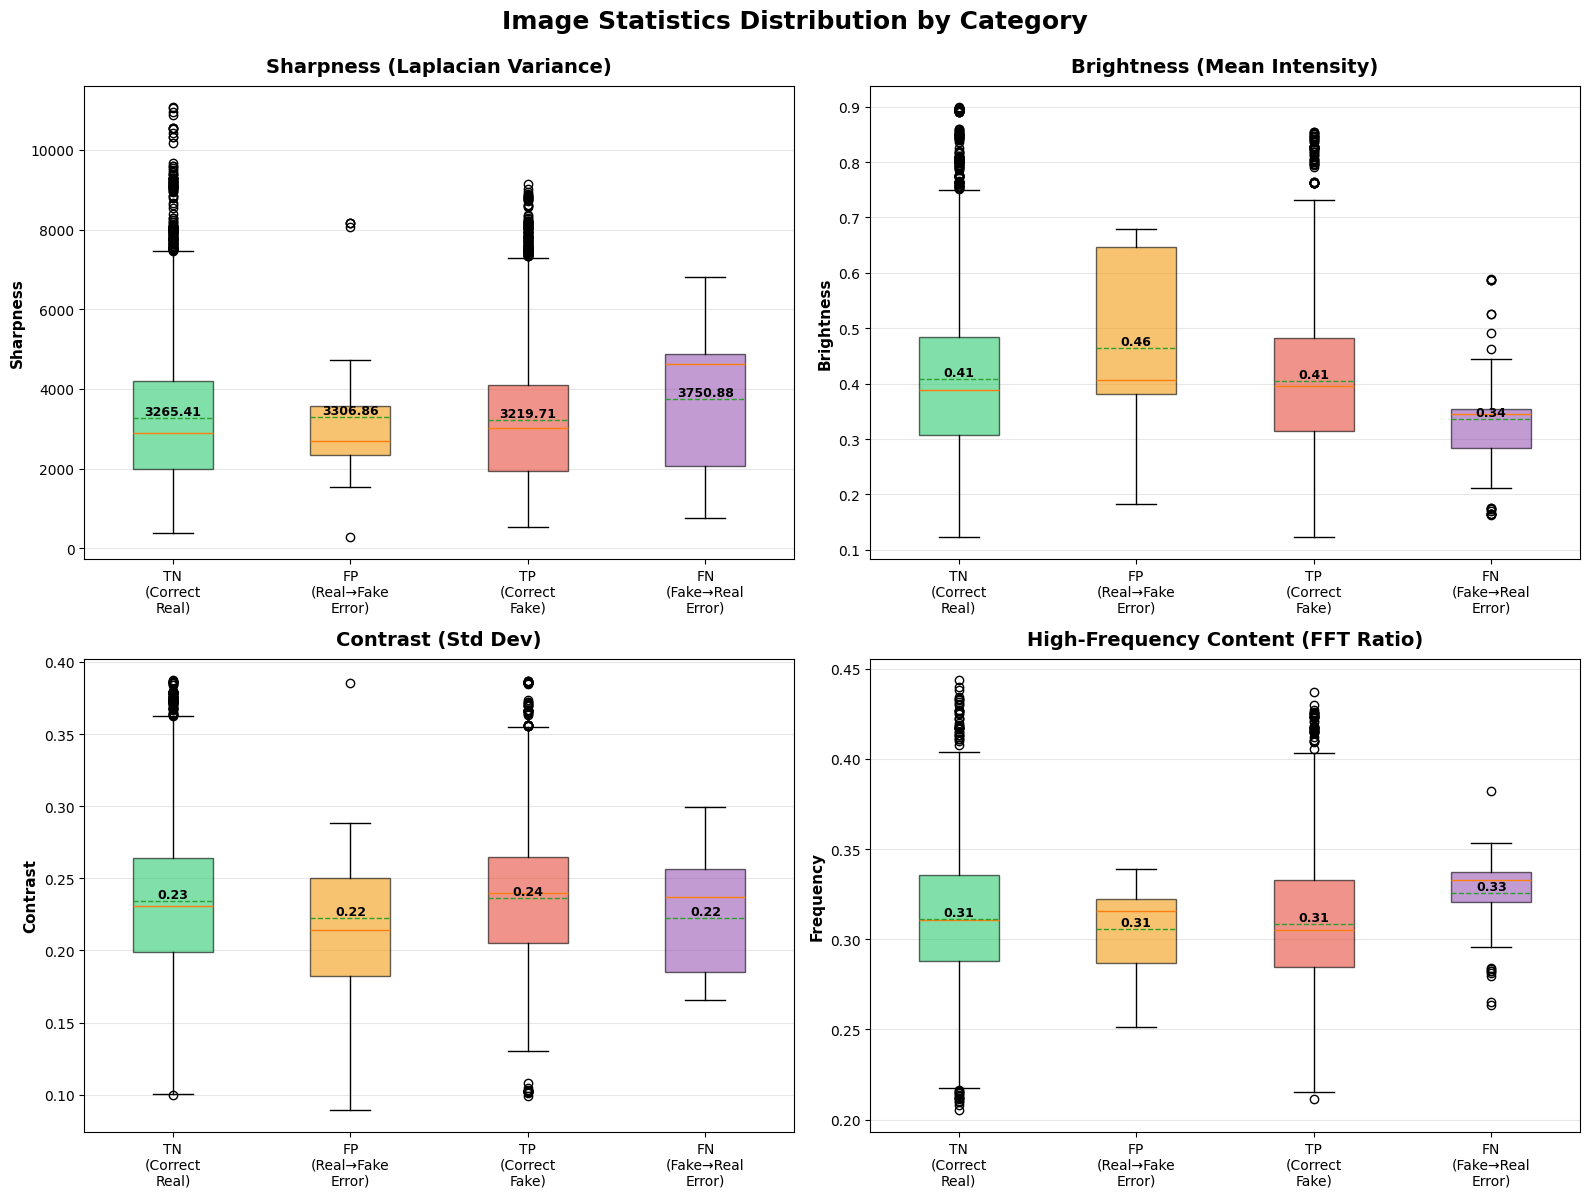

✅ Box plots created and saved!

📊 CREATING HISTOGRAM COMPARISONS


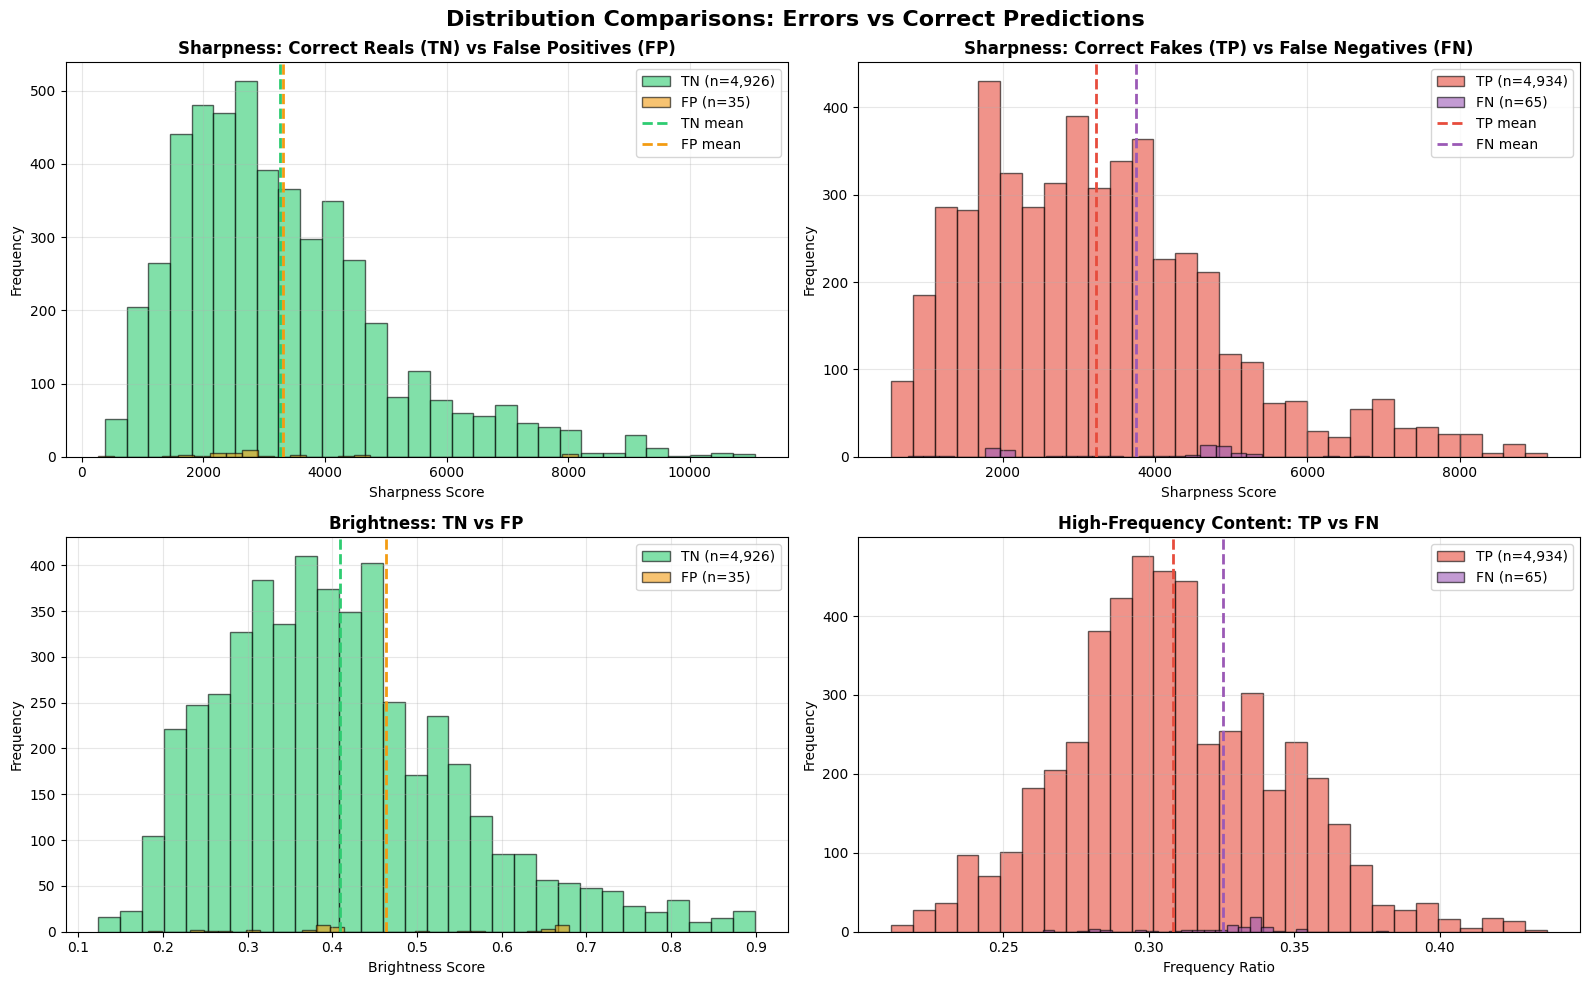

✅ Histograms created and saved!

🤖 AUTOMATED INTERPRETATION

KEY QUESTIONS TO ANSWER:

1. FALSE POSITIVES (Real→Fake):
   Are FP images significantly BLURRIER/DARKER than TN (correct reals)?

   If YES:
   ❌ Model uses quality shortcuts
   ❌ Low-quality real images get flagged as fake
   → Solution: Quality-aware loss or data augmentation

   If NO:
   ✅ Model doesn't use simple quality heuristics
   ✅ Errors are content-based, not quality-based

2. FALSE NEGATIVES (Fake→Real):
   Are FN images significantly SHARPER/BRIGHTER than TP (correct fakes)?

   If YES:
   ❌ High-quality fakes fool the model
   ❌ Model learned "sharp = real"
   → Solution: Need to detect high-quality fakes better

   If NO:
   ✅ Quality doesn't explain why fakes fooled the model
   ✅ These fakes have other realistic features

3. FREQUENCY CONTENT:
   Do FN have higher high-frequency content than TP?

   If YES:
   🔍 These fakes preserved fine details well
   🔍 More sophisticated generation method
   → Solution:

In [ ]:
# ============================================================================
# SECTION 28: IMAGE QUALITY METRICS FUNCTIONS
# ============================================================================
print(f"\n{'='*60}")
print("📊 IMAGE QUALITY STATISTICAL ANALYSIS")
print(f"{'='*60}")

from scipy import ndimage
from scipy.stats import ttest_ind

def calculate_sharpness(image_tensor):
    """
    Calculate sharpness using Laplacian variance

    Args:
        image_tensor: PyTorch tensor (C, H, W) in range [0, 1]

    Returns:
        float: Sharpness score (higher = sharper)
    """
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    sharpness = laplacian.var()
    return sharpness

def calculate_brightness(image_tensor):
    """Calculate average brightness"""
    brightness = image_tensor.mean().item()
    return brightness

def calculate_contrast(image_tensor):
    """Calculate contrast using standard deviation"""
    contrast = image_tensor.std().item()
    return contrast

def calculate_frequency_content(image_tensor):
    """
    Calculate high-frequency content using FFT

    Returns:
        float: Ratio of high-frequency energy to total energy
    """
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Apply 2D FFT
    fft = np.fft.fft2(gray)
    fft_shift = np.fft.fftshift(fft)
    magnitude = np.abs(fft_shift)

    # Define high-frequency region (outer 40% of spectrum)
    h, w = gray.shape
    center_h, center_w = h // 2, w // 2

    # Create mask for high frequencies
    y, x = np.ogrid[:h, :w]
    mask_radius = min(center_h, center_w) * 0.6
    mask = ((x - center_w)**2 + (y - center_h)**2) > mask_radius**2

    # Calculate energy ratio
    high_freq_energy = np.sum(magnitude[mask])
    total_energy = np.sum(magnitude)
    high_freq_ratio = high_freq_energy / (total_energy + 1e-10)

    return high_freq_ratio

print("✅ Metric functions defined:")
print("   • calculate_sharpness() - Laplacian variance")
print("   • calculate_brightness() - Mean pixel intensity")
print("   • calculate_contrast() - Std dev of pixels")
print("   • calculate_frequency_content() - High-freq FFT ratio")

# ============================================================================
# SECTION 29: COMPUTE METRICS FOR ALL TEST IMAGES
# ============================================================================
print(f"\n{'='*60}")
print("⏳ COMPUTING METRICS FOR TEST SET")
print(f"{'='*60}")

sharpness_scores = []
brightness_scores = []
contrast_scores = []
frequency_scores = []

start_time = time.time()

for i in tqdm(range(len(X_test)), desc="Computing metrics"):
    img_tensor = X_test[i]

    sharpness = calculate_sharpness(img_tensor)
    brightness = calculate_brightness(img_tensor)
    contrast = calculate_contrast(img_tensor)
    frequency = calculate_frequency_content(img_tensor)

    sharpness_scores.append(sharpness)
    brightness_scores.append(brightness)
    contrast_scores.append(contrast)
    frequency_scores.append(frequency)

elapsed = time.time() - start_time

# Convert to numpy arrays
sharpness_scores = np.array(sharpness_scores)
brightness_scores = np.array(brightness_scores)
contrast_scores = np.array(contrast_scores)
frequency_scores = np.array(frequency_scores)

print(f"\n✅ Metrics computed in {elapsed:.2f} seconds!")
print(f"\n📊 Metric Ranges:")
print(f"   Sharpness:  [{sharpness_scores.min():.2f}, {sharpness_scores.max():.2f}]")
print(f"   Brightness: [{brightness_scores.min():.3f}, {brightness_scores.max():.3f}]")
print(f"   Contrast:   [{contrast_scores.min():.3f}, {contrast_scores.max():.3f}]")
print(f"   Frequency:  [{frequency_scores.min():.3f}, {frequency_scores.max():.3f}]")

# ============================================================================
# SECTION 30: GROUP METRICS BY CATEGORY
# ============================================================================
print(f"\n{'='*60}")
print("📂 GROUPING METRICS BY CATEGORY")
print(f"{'='*60}")

metrics_by_category = {
    'TN': {'sharpness': [], 'brightness': [], 'contrast': [], 'frequency': []},
    'TP': {'sharpness': [], 'brightness': [], 'contrast': [], 'frequency': []},
    'FP': {'sharpness': [], 'brightness': [], 'contrast': [], 'frequency': []},
    'FN': {'sharpness': [], 'brightness': [], 'contrast': [], 'frequency': []}
}

# Populate dictionary
for i in range(len(categories)):
    cat = categories[i]
    metrics_by_category[cat]['sharpness'].append(sharpness_scores[i])
    metrics_by_category[cat]['brightness'].append(brightness_scores[i])
    metrics_by_category[cat]['contrast'].append(contrast_scores[i])
    metrics_by_category[cat]['frequency'].append(frequency_scores[i])

# Convert to numpy arrays
for cat in ['TN', 'TP', 'FP', 'FN']:
    for metric in ['sharpness', 'brightness', 'contrast', 'frequency']:
        metrics_by_category[cat][metric] = np.array(metrics_by_category[cat][metric])

print("✅ Metrics grouped by category")
print(f"\n📊 Samples per category:")
for cat in ['TN', 'TP', 'FP', 'FN']:
    count = len(metrics_by_category[cat]['sharpness'])
    print(f"   {cat}: {count:,}")

# ============================================================================
# SECTION 31: STATISTICAL ANALYSIS
# ============================================================================
print(f"\n{'='*60}")
print("📈 STATISTICAL ANALYSIS")
print(f"{'='*60}")

stats_table = []

for metric in ['sharpness', 'brightness', 'contrast', 'frequency']:
    print(f"\n{'='*60}")
    print(f"📊 {metric.upper()} ANALYSIS")
    print(f"{'='*60}")

    row = {'Metric': metric.capitalize()}

    for cat in ['TN', 'TP', 'FP', 'FN']:
        data = metrics_by_category[cat][metric]
        mean_val = np.mean(data)
        std_val = np.std(data)

        row[f'{cat}_mean'] = mean_val
        row[f'{cat}_std'] = std_val

        # Description
        category_desc = {
            'TN': 'Correct Reals',
            'TP': 'Correct Fakes',
            'FP': 'Real→Fake (Error)',
            'FN': 'Fake→Real (Error)'
        }

        print(f"\n{cat} ({category_desc[cat]}):")
        print(f"   Mean: {mean_val:.4f}")
        print(f"   Std:  {std_val:.4f}")

    stats_table.append(row)

    # Statistical significance tests
    print(f"\n🔬 Statistical Tests:")

    # Compare FP vs TN
    fp_data = metrics_by_category['FP'][metric]
    tn_data = metrics_by_category['TN'][metric]

    if len(fp_data) > 0 and len(tn_data) > 0:
        t_stat, p_value = ttest_ind(fp_data, tn_data)
        print(f"   FP vs TN: t={t_stat:.3f}, p={p_value:.4f}", end="")
        if p_value < 0.001:
            print(" *** (Highly significant difference!)")
        elif p_value < 0.05:
            print(" ** (Significant difference)")
        elif p_value < 0.1:
            print(" * (Marginally significant)")
        else:
            print(" (No significant difference)")

    # Compare FN vs TP
    fn_data = metrics_by_category['FN'][metric]
    tp_data = metrics_by_category['TP'][metric]

    if len(fn_data) > 0 and len(tp_data) > 0:
        t_stat, p_value = ttest_ind(fn_data, tp_data)
        print(f"   FN vs TP: t={t_stat:.3f}, p={p_value:.4f}", end="")
        if p_value < 0.001:
            print(" *** (Highly significant difference!)")
        elif p_value < 0.05:
            print(" ** (Significant difference)")
        elif p_value < 0.1:
            print(" * (Marginally significant)")
        else:
            print(" (No significant difference)")

print(f"\n{'='*60}")
print("✅ Statistical analysis complete!")

# ============================================================================
# SECTION 32: BOX PLOT VISUALIZATIONS
# ============================================================================
print(f"\n{'='*60}")
print("📊 CREATING DISTRIBUTION VISUALIZATIONS")
print(f"{'='*60}")

# Create box plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics_list = ['sharpness', 'brightness', 'contrast', 'frequency']
metric_titles = ['Sharpness (Laplacian Variance)', 'Brightness (Mean Intensity)',
                 'Contrast (Std Dev)', 'High-Frequency Content (FFT Ratio)']

for idx, (metric, title) in enumerate(zip(metrics_list, metric_titles)):
    ax = axes[idx]

    # Prepare data
    data_to_plot = []
    labels = []
    colors_list = []

    for cat in ['TN', 'FP', 'TP', 'FN']:
        data_to_plot.append(metrics_by_category[cat][metric])

        if cat == 'TN':
            labels.append('TN\n(Correct\nReal)')
            colors_list.append('#2ecc71')
        elif cat == 'FP':
            labels.append('FP\n(Real→Fake\nError)')
            colors_list.append('#f39c12')
        elif cat == 'TP':
            labels.append('TP\n(Correct\nFake)')
            colors_list.append('#e74c3c')
        else:
            labels.append('FN\n(Fake→Real\nError)')
            colors_list.append('#9b59b6')

    # Create box plot
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Color boxes
    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    # Style
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_ylabel(metric.capitalize(), fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Add mean values
    means = [np.mean(d) for d in data_to_plot]
    for i, mean in enumerate(means):
        ax.text(i+1, mean, f'{mean:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Image Statistics Distribution by Category',
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'image_stats_boxplots.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print("✅ Box plots created and saved!")

# ============================================================================
# SECTION 33: HISTOGRAM COMPARISONS
# ============================================================================
print(f"\n{'='*60}")
print("📊 CREATING HISTOGRAM COMPARISONS")
print(f"{'='*60}")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: TN vs FP (Sharpness)
axes[0, 0].hist(metrics_by_category['TN']['sharpness'], bins=30, alpha=0.6,
                color='#2ecc71', label=f'TN (n={len(metrics_by_category["TN"]["sharpness"]):,})',
                edgecolor='black')
axes[0, 0].hist(metrics_by_category['FP']['sharpness'], bins=30, alpha=0.6,
                color='#f39c12', label=f'FP (n={len(metrics_by_category["FP"]["sharpness"]):,})',
                edgecolor='black')
axes[0, 0].axvline(np.mean(metrics_by_category['TN']['sharpness']),
                   color='#2ecc71', linestyle='--', linewidth=2, label='TN mean')
axes[0, 0].axvline(np.mean(metrics_by_category['FP']['sharpness']),
                   color='#f39c12', linestyle='--', linewidth=2, label='FP mean')
axes[0, 0].set_title('Sharpness: Correct Reals (TN) vs False Positives (FP)',
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sharpness Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: TP vs FN (Sharpness)
axes[0, 1].hist(metrics_by_category['TP']['sharpness'], bins=30, alpha=0.6,
                color='#e74c3c', label=f'TP (n={len(metrics_by_category["TP"]["sharpness"]):,})',
                edgecolor='black')
axes[0, 1].hist(metrics_by_category['FN']['sharpness'], bins=30, alpha=0.6,
                color='#9b59b6', label=f'FN (n={len(metrics_by_category["FN"]["sharpness"]):,})',
                edgecolor='black')
axes[0, 1].axvline(np.mean(metrics_by_category['TP']['sharpness']),
                   color='#e74c3c', linestyle='--', linewidth=2, label='TP mean')
axes[0, 1].axvline(np.mean(metrics_by_category['FN']['sharpness']),
                   color='#9b59b6', linestyle='--', linewidth=2, label='FN mean')
axes[0, 1].set_title('Sharpness: Correct Fakes (TP) vs False Negatives (FN)',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sharpness Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Brightness (TN vs FP)
axes[1, 0].hist(metrics_by_category['TN']['brightness'], bins=30, alpha=0.6,
                color='#2ecc71', label=f'TN (n={len(metrics_by_category["TN"]["brightness"]):,})',
                edgecolor='black')
axes[1, 0].hist(metrics_by_category['FP']['brightness'], bins=30, alpha=0.6,
                color='#f39c12', label=f'FP (n={len(metrics_by_category["FP"]["brightness"]):,})',
                edgecolor='black')
axes[1, 0].axvline(np.mean(metrics_by_category['TN']['brightness']),
                   color='#2ecc71', linestyle='--', linewidth=2)
axes[1, 0].axvline(np.mean(metrics_by_category['FP']['brightness']),
                   color='#f39c12', linestyle='--', linewidth=2)
axes[1, 0].set_title('Brightness: TN vs FP', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Brightness Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Frequency (TP vs FN)
axes[1, 1].hist(metrics_by_category['TP']['frequency'], bins=30, alpha=0.6,
                color='#e74c3c', label=f'TP (n={len(metrics_by_category["TP"]["frequency"]):,})',
                edgecolor='black')
axes[1, 1].hist(metrics_by_category['FN']['frequency'], bins=30, alpha=0.6,
                color='#9b59b6', label=f'FN (n={len(metrics_by_category["FN"]["frequency"]):,})',
                edgecolor='black')
axes[1, 1].axvline(np.mean(metrics_by_category['TP']['frequency']),
                   color='#e74c3c', linestyle='--', linewidth=2)
axes[1, 1].axvline(np.mean(metrics_by_category['FN']['frequency']),
                   color='#9b59b6', linestyle='--', linewidth=2)
axes[1, 1].set_title('High-Frequency Content: TP vs FN', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Frequency Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Distribution Comparisons: Errors vs Correct Predictions',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['save_dir'], 'image_stats_histograms.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print("✅ Histograms created and saved!")

# ============================================================================
# SECTION 34: AUTOMATED INTERPRETATION
# ============================================================================
print(f"\n{'='*60}")
print("🤖 AUTOMATED INTERPRETATION")
print(f"{'='*60}")

print("""
KEY QUESTIONS TO ANSWER:

1. FALSE POSITIVES (Real→Fake):
   Are FP images significantly BLURRIER/DARKER than TN (correct reals)?

   If YES:
   ❌ Model uses quality shortcuts
   ❌ Low-quality real images get flagged as fake
   → Solution: Quality-aware loss or data augmentation

   If NO:
   ✅ Model doesn't use simple quality heuristics
   ✅ Errors are content-based, not quality-based

2. FALSE NEGATIVES (Fake→Real):
   Are FN images significantly SHARPER/BRIGHTER than TP (correct fakes)?

   If YES:
   ❌ High-quality fakes fool the model
   ❌ Model learned "sharp = real"
   → Solution: Need to detect high-quality fakes better

   If NO:
   ✅ Quality doesn't explain why fakes fooled the model
   ✅ These fakes have other realistic features

3. FREQUENCY CONTENT:
   Do FN have higher high-frequency content than TP?

   If YES:
   🔍 These fakes preserved fine details well
   🔍 More sophisticated generation method
   → Solution: Frequency-aware loss
""")

# Automated analysis
fp_sharp = metrics_by_category['FP']['sharpness']
tn_sharp = metrics_by_category['TN']['sharpness']

if len(fp_sharp) > 0 and len(tn_sharp) > 0:
    t_stat, p_val = ttest_ind(fp_sharp, tn_sharp)
    fp_mean = np.mean(fp_sharp)
    tn_mean = np.mean(tn_sharp)

    print(f"\n🔍 False Positives vs Correct Reals (Sharpness):")
    print(f"   FP mean: {fp_mean:.2f}")
    print(f"   TN mean: {tn_mean:.2f}")
    print(f"   Difference: {fp_mean - tn_mean:.2f}")
    print(f"   p-value: {p_val:.4f}")

    if p_val < 0.05:
        if fp_mean < tn_mean:
            print(f"\n   ⚠️ FINDING: False positives are SIGNIFICANTLY BLURRIER")
            print(f"   ❌ Model likely uses blur as a cue for fake")
            print(f"   💡 Recommendation: Implement quality-aware loss")
        else:
            print(f"\n   🔍 FINDING: False positives are SHARPER (unusual)")
            print(f"   🤔 Unexpected pattern - investigate further")
    else:
        print(f"\n   ✅ FINDING: No significant quality difference")
        print(f"   ✅ Model doesn't use sharpness shortcuts")

# Check FN vs TP
fn_sharp = metrics_by_category['FN']['sharpness']
tp_sharp = metrics_by_category['TP']['sharpness']

if len(fn_sharp) > 0 and len(tp_sharp) > 0:
    t_stat, p_val = ttest_ind(fn_sharp, tp_sharp)
    fn_mean = np.mean(fn_sharp)
    tp_mean = np.mean(tp_sharp)

    print(f"\n🔍 False Negatives vs Correct Fakes (Sharpness):")
    print(f"   FN mean: {fn_mean:.2f}")
    print(f"   TP mean: {tp_mean:.2f}")
    print(f"   Difference: {fn_mean - tp_mean:.2f}")
    print(f"   p-value: {p_val:.4f}")

    if p_val < 0.05:
        if fn_mean > tp_mean:
            print(f"\n   ⚠️ FINDING: False negatives are SIGNIFICANTLY SHARPER")
            print(f"   ❌ High-quality fakes fool the model")
            print(f"   💡 Recommendation: Model needs better fake detection for sharp images")
        else:
            print(f"\n   🔍 FINDING: False negatives are BLURRIER (unusual)")
            print(f"   🤔 Unexpected pattern - investigate further")
    else:
        print(f"\n   ✅ FINDING: No significant quality difference")
        print(f"   ✅ Errors aren't explained by sharpness alone")

print(f"\n{'='*60}")
print("✅ IMAGE STATISTICS ANALYSIS COMPLETE!")
print(f"{'='*60}")
print(f"\n📁 All visualizations saved to: {CONFIG['save_dir']}")
print("""
📊 SUMMARY:
   • Computed 4 quality metrics for all test images
   • Grouped by prediction category (TN/TP/FP/FN)
   • Performed statistical significance tests
   • Created box plots and histograms
   • Generated automated interpretations

💡 NEXT STEPS:
   • Review the p-values to identify significant differences
   • Check if errors correlate with image quality
   • Use findings to improve model or data augmentation
""")

---

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def evaluate_model_complete(model, test_loader, device, train_accuracy=None):
    """
    Complete evaluation with confusion matrix and metrics table
    """
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    # Collect predictions
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    test_accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds) * 100
    recall = recall_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds) * 100
    roc_auc = roc_auc_score(all_labels, all_probs[:, 1]) * 100

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Per-class accuracy
    real_correct = cm[0, 0]
    real_total = cm[0].sum()
    fake_correct = cm[1, 1]
    fake_total = cm[1].sum()
    real_accuracy = (real_correct / real_total) * 100
    fake_accuracy = (fake_correct / fake_total) * 100

    # Error analysis
    fp_rate = (cm[0, 1] / cm[0].sum()) * 100
    fn_rate = (cm[1, 0] / cm[1].sum()) * 100

    # Train-Test Gap
    if train_accuracy is not None:
        gap = train_accuracy - test_accuracy
        gap_text = f"{gap:.2f}%"
        if gap < 1:
            gap_status = "(excellent generalization)"
        elif gap < 2:
            gap_status = "(very good generalization)"
        elif gap < 5:
            gap_status = "(good generalization)"
        else:
            gap_status = "(some overfitting)"
    else:
        gap_text = "N/A"
        gap_status = ""

    # ========================
    # PLOT 1: CONFUSION MATRIX
    # ========================
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Confusion Matrix
    ax1 = axes[0]
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=['Real (0)', 'Fake (1)'],
                yticklabels=['Real (0)', 'Fake (1)'],
                cbar_kws={'label': 'Count'},
                ax=ax1)

    # Add counts and percentages
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            total = cm[i].sum()
            percentage = (count / total) * 100

            # Count (large, white)
            ax1.text(j + 0.5, i + 0.4, f'{count}',
                    ha='center', va='center',
                    fontsize=20, fontweight='bold', color='white')

            # Percentage (smaller, red)
            ax1.text(j + 0.5, i + 0.65, f'({percentage:.1f}%)',
                    ha='center', va='center',
                    fontsize=12, color='darkred', fontweight='bold')

    ax1.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

    # ========================
    # PLOT 2: METRICS TABLE
    # ========================
    ax2 = axes[1]
    ax2.axis('off')

    # Create table data
    table_data = [
        ['Metric', 'Training', 'Test'],
        ['Accuracy', f'{train_accuracy:.2f}%' if train_accuracy else '-', f'{test_accuracy:.2f}%'],
        ['Precision', '-', f'{precision:.2f}%'],
        ['Recall', '-', f'{recall:.2f}%'],
        ['F1-Score', '-', f'{f1:.2f}%'],
        ['ROC-AUC', '-', f'{roc_auc:.2f}%'],
        ['Loss', '-', '-']
    ]

    # Create table
    table = ax2.table(cellText=table_data,
                     cellLoc='center',
                     loc='upper center',
                     bbox=[0, 0.55, 1, 0.4])

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Style header row
    for i in range(3):
        cell = table[(0, i)]
        cell.set_facecolor('#4472C4')
        cell.set_text_props(weight='bold', color='white')

    # Style data rows
    for i in range(1, 7):
        for j in range(3):
            cell = table[(i, j)]
            if j == 0:  # Metric name column
                cell.set_facecolor('#E7E6E6')
                cell.set_text_props(weight='bold')
            else:
                cell.set_facecolor('white')

    # Add gap text
    gap_y = 0.45
    ax2.text(0.5, gap_y, f'Train-Test Gap: {gap_text} {gap_status}',
            ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    # Add per-class performance
    perf_y = 0.30
    ax2.text(0.5, perf_y, 'Per-Class Performance (Test Set):',
            ha='center', va='center', fontsize=11, fontweight='bold')

    ax2.text(0.1, perf_y - 0.06, f'• Real videos: {real_accuracy:.2f}% accuracy ({real_correct:,}/{real_total:,} correct)',
            ha='left', va='center', fontsize=10)

    ax2.text(0.1, perf_y - 0.12, f'• Fake videos: {fake_accuracy:.2f}% accuracy ({fake_correct:,}/{fake_total:,} correct)',
            ha='left', va='center', fontsize=10)

    # Add error analysis
    error_y = 0.10
    ax2.text(0.5, error_y, 'Error Analysis:',
            ha='center', va='center', fontsize=11, fontweight='bold')

    ax2.text(0.1, error_y - 0.06, f'• False Positive Rate: {fp_rate:.2f}% ({cm[0,1]} real videos misclassified as fake)',
            ha='left', va='center', fontsize=10)

    ax2.text(0.1, error_y - 0.12, f'• False Negative Rate: {fn_rate:.2f}% ({cm[1,0]} fake videos missed)',
            ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # ========================
    # PRINT SUMMARY
    # ========================
    print("\n" + "="*60)
    print("📊 EVALUATION SUMMARY")
    print("="*60)
    print(f"\n✅ Test Accuracy: {test_accuracy:.2f}%")
    print(f"✅ Precision: {precision:.2f}%")
    print(f"✅ Recall: {recall:.2f}%")
    print(f"✅ F1-Score: {f1:.2f}%")
    print(f"✅ ROC-AUC: {roc_auc:.2f}%")

    if train_accuracy:
        print(f"\n📉 Train-Test Gap: {gap:.2f}% {gap_status}")

    print(f"\n📍 Per-Class:")
    print(f"   Real: {real_accuracy:.2f}% ({real_correct:,}/{real_total:,})")
    print(f"   Fake: {fake_accuracy:.2f}% ({fake_correct:,}/{fake_total:,})")

    print(f"\n⚠️ Errors:")
    print(f"   False Positive Rate: {fp_rate:.2f}% ({cm[0,1]} samples)")
    print(f"   False Negative Rate: {fn_rate:.2f}% ({cm[1,0]} samples)")
    print("="*60)

    return {
        'accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'train_test_gap': gap if train_accuracy else None
    }

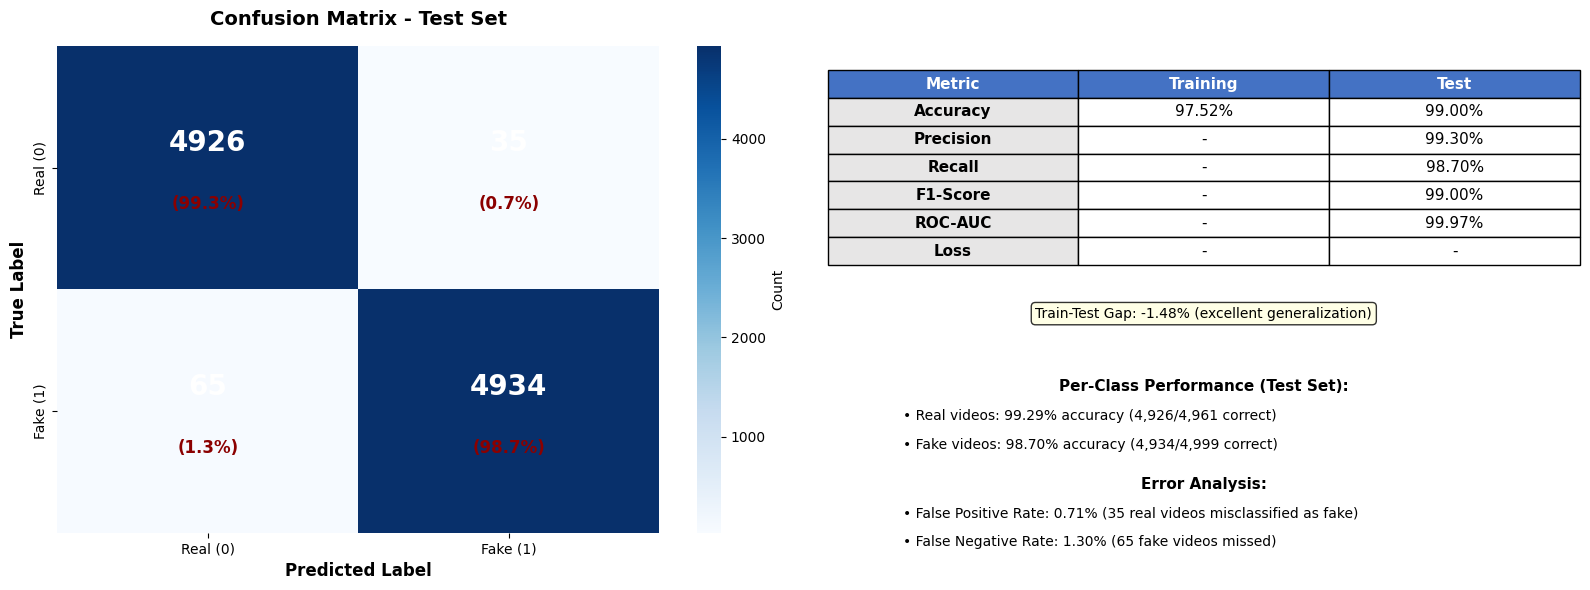


📊 EVALUATION SUMMARY

✅ Test Accuracy: 99.00%
✅ Precision: 99.30%
✅ Recall: 98.70%
✅ F1-Score: 99.00%
✅ ROC-AUC: 99.97%

📉 Train-Test Gap: -1.48% (excellent generalization)

📍 Per-Class:
   Real: 99.29% (4,926/4,961)
   Fake: 98.70% (4,934/4,999)

⚠️ Errors:
   False Positive Rate: 0.71% (35 samples)
   False Negative Rate: 1.30% (65 samples)


In [ ]:
# After training
final_train_accuracy = 97.52  # Your final training accuracy

# Run evaluation
results = evaluate_model_complete(
    model=cnn,
    test_loader=test_loader,
    device=device,
    train_accuracy=final_train_accuracy  # Pass your training accuracy
)

# Results will show:
# 1. Confusion matrix plot (left)
# 2. Metrics table (right)
# 3. Printed summary

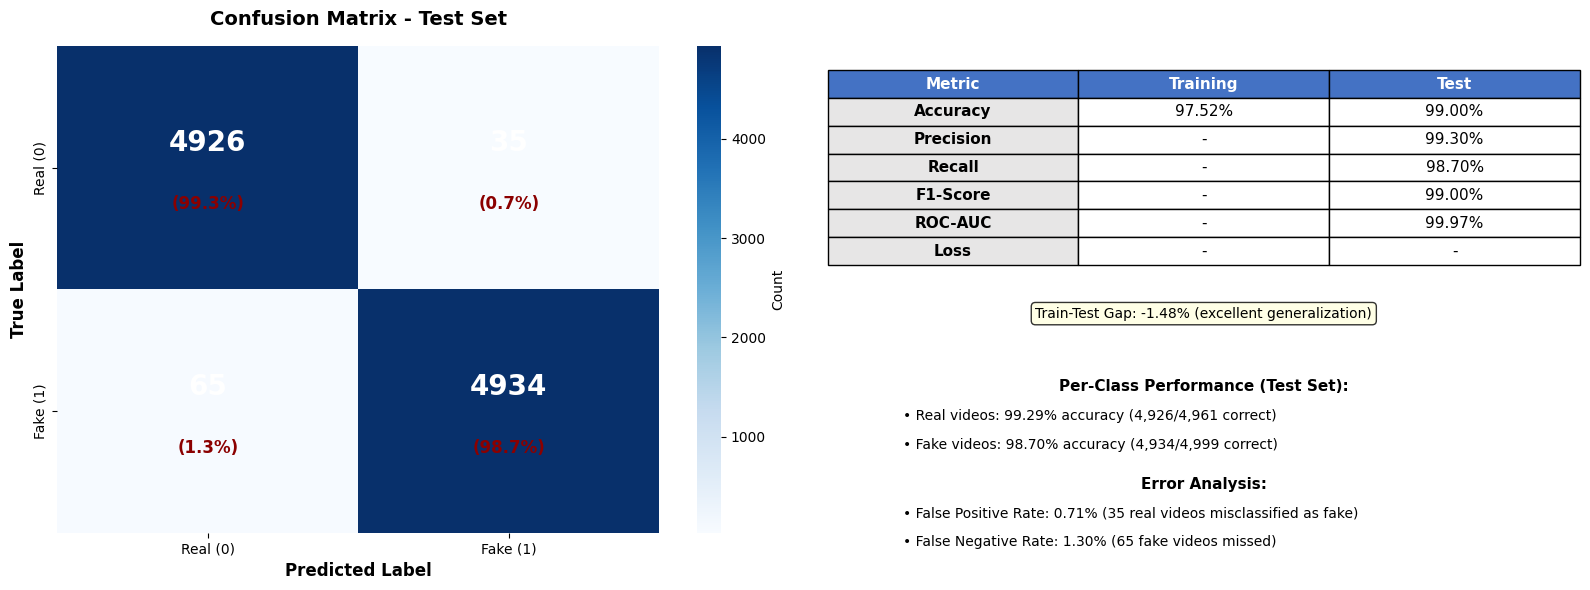


📊 EVALUATION SUMMARY

📈 Overall Metrics:
   Accuracy:  99.00%
   Precision: 99.30%
   Recall:    98.70%
   F1-Score:  99.00%
   ROC-AUC:   99.97%

📉 Train-Test Gap: -1.48% (excellent generalization)

📊 Confusion Matrix Breakdown:
   True Negatives  (Real predicted as Real): 4,926
   False Positives (Real predicted as Fake): 35
   False Negatives (Fake predicted as Real): 65
   True Positives  (Fake predicted as Fake): 4,934

📍 Per-Class Performance:
   Real videos: 99.29% accuracy (4,926/4,961 correct)
   Fake videos: 98.70% accuracy (4,934/4,999 correct)

⚠️ Error Analysis:
   False Positive Rate: 0.71%
      (Real videos wrongly flagged as fake)
   False Negative Rate: 1.30%
      (Fake videos missed - most dangerous!)


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_probs[:, 1])

# Per-class accuracy
real_mask = all_labels == 0
fake_mask = all_labels == 1
real_correct = (all_predictions[real_mask] == 0).sum()
fake_correct = (all_predictions[fake_mask] == 1).sum()
real_total = real_mask.sum()
fake_total = fake_mask.sum()
real_accuracy = (real_correct / real_total) * 100
fake_accuracy = (fake_correct / fake_total) * 100

# Error rates
false_positive_rate = cm[0, 1] / cm[0].sum() * 100
false_negative_rate = cm[1, 0] / cm[1].sum() * 100

# Train-test gap (replace with your actual training accuracy)
train_accuracy = 97.52  # Your final training accuracy
test_accuracy = accuracy * 100
gap = train_accuracy - test_accuracy

if gap < 1:
    gap_status = "(excellent generalization)"
elif gap < 2:
    gap_status = "(very good generalization)"
elif gap < 5:
    gap_status = "(good generalization)"
else:
    gap_status = "(some overfitting)"

# ========================
# CREATE VISUALIZATION
# ========================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ========================
# LEFT: CONFUSION MATRIX
# ========================
ax1 = axes[0]

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'],
            cbar_kws={'label': 'Count'},
            ax=ax1)

# Add counts and percentages
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        total = cm[i].sum()
        percentage = (count / total) * 100

        # Count (large, white)
        ax1.text(j + 0.5, i + 0.4, f'{count}',
                ha='center', va='center',
                fontsize=20, fontweight='bold', color='white')

        # Percentage (smaller, red)
        ax1.text(j + 0.5, i + 0.65, f'({percentage:.1f}%)',
                ha='center', va='center',
                fontsize=12, color='darkred', fontweight='bold')

ax1.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# ========================
# RIGHT: METRICS TABLE
# ========================
ax2 = axes[1]
ax2.axis('off')

# Create table data
table_data = [
    ['Metric', 'Training', 'Test'],
    ['Accuracy', f'{train_accuracy:.2f}%', f'{test_accuracy:.2f}%'],
    ['Precision', '-', f'{precision*100:.2f}%'],
    ['Recall', '-', f'{recall*100:.2f}%'],
    ['F1-Score', '-', f'{f1*100:.2f}%'],
    ['ROC-AUC', '-', f'{roc_auc*100:.2f}%'],
    ['Loss', '-', '-']
]

# Create table
table = ax2.table(cellText=table_data,
                 cellLoc='center',
                 loc='upper center',
                 bbox=[0, 0.55, 1, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style header row
for i in range(3):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white')

# Style data rows
for i in range(1, 7):
    for j in range(3):
        cell = table[(i, j)]
        if j == 0:  # Metric name column
            cell.set_facecolor('#E7E6E6')
            cell.set_text_props(weight='bold')
        else:
            cell.set_facecolor('white')

# Add gap text
gap_y = 0.45
ax2.text(0.5, gap_y, f'Train-Test Gap: {gap:.2f}% {gap_status}',
        ha='center', va='center', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# Add per-class performance
perf_y = 0.30
ax2.text(0.5, perf_y, 'Per-Class Performance (Test Set):',
        ha='center', va='center', fontsize=11, fontweight='bold')

ax2.text(0.1, perf_y - 0.06, f'• Real videos: {real_accuracy:.2f}% accuracy ({real_correct:,}/{real_total:,} correct)',
        ha='left', va='center', fontsize=10)

ax2.text(0.1, perf_y - 0.12, f'• Fake videos: {fake_accuracy:.2f}% accuracy ({fake_correct:,}/{fake_total:,} correct)',
        ha='left', va='center', fontsize=10)

# Add error analysis
error_y = 0.10
ax2.text(0.5, error_y, 'Error Analysis:',
        ha='center', va='center', fontsize=11, fontweight='bold')

ax2.text(0.1, error_y - 0.06, f'• False Positive Rate: {false_positive_rate:.2f}% ({cm[0,1]} real videos misclassified as fake)',
        ha='left', va='center', fontsize=10)

ax2.text(0.1, error_y - 0.12, f'• False Negative Rate: {false_negative_rate:.2f}% ({cm[1,0]} fake videos missed)',
        ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# ========================
# PRINT SUMMARY
# ========================
print("\n" + "="*60)
print("📊 EVALUATION SUMMARY")
print("="*60)

print(f"\n📈 Overall Metrics:")
print(f"   Accuracy:  {test_accuracy:.2f}%")
print(f"   Precision: {precision*100:.2f}%")
print(f"   Recall:    {recall*100:.2f}%")
print(f"   F1-Score:  {f1*100:.2f}%")
print(f"   ROC-AUC:   {roc_auc*100:.2f}%")

print(f"\n📉 Train-Test Gap: {gap:.2f}% {gap_status}")

print(f"\n📊 Confusion Matrix Breakdown:")
print(f"   True Negatives  (Real predicted as Real): {cm[0, 0]:,}")
print(f"   False Positives (Real predicted as Fake): {cm[0, 1]:,}")
print(f"   False Negatives (Fake predicted as Real): {cm[1, 0]:,}")
print(f"   True Positives  (Fake predicted as Fake): {cm[1, 1]:,}")

print(f"\n📍 Per-Class Performance:")
print(f"   Real videos: {real_accuracy:.2f}% accuracy ({real_correct:,}/{real_total:,} correct)")
print(f"   Fake videos: {fake_accuracy:.2f}% accuracy ({fake_correct:,}/{fake_total:,} correct)")

print(f"\n⚠️ Error Analysis:")
print(f"   False Positive Rate: {false_positive_rate:.2f}%")
print(f"      (Real videos wrongly flagged as fake)")
print(f"   False Negative Rate: {false_negative_rate:.2f}%")
print(f"      (Fake videos missed - most dangerous!)")

print("="*60)